# LDA 泛函核

这一节我们简单了解 LDA 泛函核的程序实现；这是我们的第一个 DFT 计算的文档。

LDA (Local Density Approximation) 的发展可以追溯到 19 世纪 30 年代，它不仅在发展上比 DFT 更早，也同时是 DFT 的基础。同时，LDA 的公式相对来说比较简单，因此程序上可以用较短的代码长度实现。但 LDA 的精度远远不足以处理普遍的化学问题；以后的文档我们会使用 GGA (Generalized Gradient Approximation) 作为基本框架进行计算。因此，这一节我们只是稍稍涉水 DFT 程序；用于以后文档与 pyxdh 的完整的格点积分介绍将会放在下一节的 GGA 自洽场讨论中。

这一节以及以后的文档对 DFT 的叙述都只是从程序出发，而不讨论 DFT 的理论和推导。

In [1]:
import numpy as np
from pyscf import gto, lib, dft
from matplotlib import pyplot as plt
from functools import partial

from pyxdh.Utilities.test_molecules import Mol_H2O2
from pyxdh.DerivOnce import GradSCF

np.set_printoptions(5, suppress=True, linewidth=120)
np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])

DFT 的积分按照约定俗成和一些理论支撑，通常分为交换部分 (Exchange) 与相关部分 (Correlation)。对于 LDA，交换部分是 Slater 泛函 (参考 [Wikipedia 页面](https://en.wikipedia.org/wiki/Local-density_approximation#Exchange_functional))；相关部分没有确定的形式，一般使用 VWN5 泛函 <cite data-cite="Vosko-Nusair.CJP.1980.58"></cite> (Gaussian 中可能会默认使用 VWN3 泛函，因此使用与 VWN 有关泛函时，需要特别注意这个问题)。

这一节我们的讨论对象便是 Slater 交换泛函与 VWN5 相关泛函，并且着重讨论形式较为简单的 Slater 泛函。

下述代码块生成双氧水分子与其对应的 (99, 590) 格点。

In [2]:
mol = Mol_H2O2().mol
grids = Mol_H2O2().gen_grids()

同时我们定义下述两个经常使用到，并且与泛函无关的量。`nao` 是 AO 基组大小，而 `ngrids` 是格点数量。

In [3]:
nao, ngrids = mol.nao, grids.weights.size
nao, ngrids

(22, 130776)

## Slater 交换泛函

### Slater 交换泛函能量结果

Slater 交换泛函能量的表达式是

$$
\begin{equation}
E_\mathrm{x}^{\mathrm{Slater}}[\rho] = - \frac{3}{4}\left( \frac{3}{\pi} \right)^{1/3} \int\rho(\boldsymbol{r})^{4/3} \, \mathrm{d} \boldsymbol{r}
\end{equation}
$$

对于 Gaussian，如果要获得 Slater 泛函自洽场下双氧水分子的结果，需要使用以下关键词：

```
#p HFS/6-31G nosymm Integral(Grid=99590)
```

而在 PySCF 中，我们用如下方式定义 Slater 泛函的自洽场：

In [4]:
scf_eng_s = dft.RKS(mol)
scf_eng_s.grids = grids
scf_eng_s.xc = "Slater"
scf_eng_s.kernel()

-149.06413916042908

我们可以将 `scf_eng_s` 代入 pyxdh 框架中，以方便后续的一些计算代码：

In [5]:
config = {"scf_eng": scf_eng_s}
scfh_s = GradSCF(config)

我们曾经在 [RHF 能量参考实现](basic_rhf.ipynb#RHF-能量实现参考) 中讨论过 RHF 波函数能量；对于 LDA 而言，总能量的表达式相对于 RHF，贡献项少了 RHF 交换积分贡献，而多了交换相关泛函贡献 (若泛函是 Slater 交换泛函，则多出的部分是 Slater 泛函能量)：

$$
E_\mathrm{elec}[D_{\mu \nu}] = (h_{\mu \nu} + \frac{1}{2} J_{\mu \nu} [D_{\kappa \lambda}]) D_{\mu \nu} + E_\mathrm{x}^\mathrm{Slater} [\rho]
$$

其中，Hamiltonian Core 与库伦积分的能量贡献 $(h_{\mu \nu} + \frac{1}{2} J_{\mu \nu} [D_{\kappa \lambda}]) D_{\mu \nu}$ 是容易计算的；因此我们很容易地倒推 Slater 泛函能量 `eng_xc_s`：

$$
E_\mathrm{x}^\mathrm{Slater} [\rho] = E_\mathrm{elec}[D_{\mu \nu}] - (h_{\mu \nu} + \frac{1}{2} J_{\mu \nu} [D_{\kappa \lambda}]) D_{\mu \nu}
$$

In [6]:
eng_xc_s = scf_eng_s.energy_elec()[0] - ((scfh_s.H_0_ao + 0.5 * scf_eng_s.get_j()) * scfh_s.D).sum()
eng_xc_s

-15.553774010932813

后面几段的任务将会是重复上述 Slater 泛函能量 $E_\mathrm{x}^\mathrm{Slater} [\rho]$。

### 轨道格点

<div class="alert alert-info">

**记号说明**

在这一节公式中，以及整个文档的代码中，

* 下标 $g$ 代表 DFT 格点。

* $w_g$ 代表 DFT 格点所具有的权重。

以后的文档出于简化公式的目的，下标 $g$ 与 $w_g$ 将不会出现在公式中；但这一节会写出完整的计算公式。

</div>

回顾上一节，如果我们希望通过数值积分的方式求取 $E_\mathrm{x}^{\mathrm{Slater}}[\rho]$，那么其表达式应当是

$$
E_\mathrm{x}^{\mathrm{Slater}}[\rho] = - \frac{3}{4}\left( \frac{3}{\pi} \right)^{1/3} w_g \rho_g^{4/3}
$$

其中，上式根据 Einstein Summation Convention，等式右边对 $g$ 求和。权重格点我们可以通过 `grids.weights` 直接获得；那么，求取 $E_\mathrm{x}^{\mathrm{Slater}}[\rho]$ 的第一步就是给出 $\rho_g$。

在 PySCF 中，与 DFT 格点有关的许多程序集中在 `dft.numint.NumInt` 类中。我们定义以下类实例 `ni`：

In [7]:
ni = dft.numint.NumInt()

通过 `ni.block_loop` 成员函数，我们可以获得 `ao`/`grid_ao` 格点的原子轨道 $\phi_{g \mu}$ 以及其对电子坐标分量的导数、`mask` 遮罩、`weights`/`grid_weights` 格点权重 $w_g$、以及 `coords`/`grid_coords` 格点坐标：

In [8]:
grid_ao, _, grid_weights, grid_coords = np.zeros((4, ngrids, nao)), _, np.zeros(ngrids), np.zeros((ngrids, 3))
g_start, g_end, g_mem = 0, 0, 2000
for ao, mask, weights, coords in ni.block_loop(mol, grids, nao, 1, g_mem):
    g_end = g_start + ao.shape[1]
    g_slice = slice(g_start, g_end)
    grid_ao[:, g_slice, :] = ao
    grid_weights[g_slice] = weights
    grid_coords[g_slice] = coords
    g_start = g_end

其中，格点遮罩和格点坐标以后并不会经常使用。格点权重和坐标还可以分别通过 `grids.weights` 和 `grids.coords` 直接给出；下面的代码单元验证通过 `ni.block_loop` 给出的权重和坐标，以及 `grids` 直接给出的权重和坐标是等价的：

In [9]:
print(np.allclose(grid_weights, grids.weights))
print(np.allclose(grid_coords, grids.coords))

True
True


<div class="alert alert-info">

**任务 (1)**

1. 请尽可能解释生成 `grid_ao`、`grid_weights`、`grid_coords` 代码的过程。

2. 下面一行代码似乎能直接生成 `grid_ao`、`grid_weights`、`grid_coords` 三者；但作者不推荐这么使用代码。请解释原因。

    ```python
    grid_ao, _, grid_weights, grid_coords = next(ni.block_loop(mol, grids, nao, 1, g_mem))
    ```
    
    提示：首先注意到 `ni.block_loop` 的返回量是迭代器，而 `next` 在 Python 中是用来返回迭代器中下一个迭代量；其次思考或通过 Hacking 程序或查看 API 文档了解 `g_mem` 参数的意义。

</div>

我们以后只用到不包含导数的原子轨道格点 $\phi_{g \mu}$，因此定义下述变量 `ao_0`：

In [10]:
ao_0 = grid_ao[0]
ao_0.shape

(130776, 22)

### 密度格点

我们知道，分子的电子态密度可以写作：

$$
\rho (\boldsymbol{r}) = \phi_i (\boldsymbol{r}) \phi_i (\boldsymbol{r})
$$

而分子轨道又可以写作

$$
\phi_i (\boldsymbol{r}) = C_{\mu i} \phi_\mu (\boldsymbol{r})
$$

因此，

$$
\rho (\boldsymbol{r}) = C_{\mu i} C_{\nu i} \phi_\mu (\boldsymbol{r}) \phi_\nu (\boldsymbol{r}) = D_{\mu \nu} \phi_\mu (\boldsymbol{r}) \phi_\nu (\boldsymbol{r})
$$

上面是以 $\boldsymbol{r}$ 的函数来定义的；如果用格点来定义的话，则密度格点 `rho_s_0` 为

$$
\rho_g = D_{\mu \nu} \phi_{g \mu} \phi_{g \nu}
$$

In [11]:
rho_s_0 = np.einsum("uv, gu, gv -> g", scfh_s.D, ao_0, ao_0)

密度的一个非常重要的性质是

$$
n_\mathrm{elec} = \int \rho(\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
$$

其中，$n_\mathrm{elec}$ 是电子总数，对于双氧水而言是 18。如果用格点积分来表示上式，则

$$
n_\mathrm{elec} = w_g \rho_g
$$

In [12]:
(rho_s_0 * grids.weights).sum()

18.00000019228845

<div class="alert alert-info">

**任务 (2)**

1. 我们只说生成了密度格点，但我们其实还没有进行过量纲分析。请根据电子数格点积分的程序结果，判断 `rho_s_0` $\rho_g$ 向量中每个元素的量纲是什么。

    提示：格点权重 $w_g$ 的量纲认为是 $[\mathrm{L}]^3$。

</div>

### Slater 交换泛函能量

重新回顾 Slater 交换泛函能量的表达式：

$$
E_\mathrm{x}^{\mathrm{Slater}}[\rho] = - \frac{3}{4}\left( \frac{3}{\pi} \right)^{1/3} \int \rho(\boldsymbol{r})^{4/3} \, \mathrm{d} \boldsymbol{r}
$$

如果要将上式写为格点积分的表达式，则

$$
E_\mathrm{x}^{\mathrm{Slater}}[\rho] = - \frac{3}{4}\left( \frac{3}{\pi} \right)^{1/3} w_g \rho_g^{4/3}
$$

In [13]:
(- 3/4 * (3/np.pi)**(1/3) * rho_s_0**(4/3) * grids.weights).sum()

-15.553774010932845

该能量与方才导出的 `eng_xc_s` 几乎相等。

### Slater 交换泛函核

Slater 交换泛函由于形式非常简单，可以直接给出交换相关泛函的能量；但一般来说，泛函是通过核 (kernel) $f[\rho]$ 先定义，随后根据下式给出泛函能量：

$$
E_\mathrm{x}^{\mathrm{Slater}}[\rho] = \int f^\mathrm{Slater} [\rho] \rho(\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
$$

容易知道，Slater 的泛函核是

$$
f^\mathrm{Slater} [\rho] = - \frac{3}{4}\left( \frac{3}{\pi} \right)^{1/3} \rho^{1/3}
$$

那么，对于当前的电子态密度格点 `rho_s_0` $\rho_g$，Slater 泛函核的格点 `kernel_s` 为

$$
f_g = - \frac{3}{4}\left( \frac{3}{\pi} \right)^{1/3} \rho^{1/3}_g
$$

In [14]:
kernel_s = - 3/4 * (3/np.pi)**(1/3) * rho_s_0**(1/3)

那么 Slater 交换能则还可以写为

$$
E_\mathrm{x}^{\mathrm{Slater}}[\rho] = w_g f_g \rho_g
$$

In [15]:
(grids.weights * kernel_s * rho_s_0).sum()

-15.553774010932846

### PySCF 程序计算 Slater 交换能

上一小段似乎比较冗余：我们完全可以不借助交换泛函核进行格点积分。但在 PySCF 中，流程化的做法是先生成交换泛函核，再通过 $E_\mathrm{xc} [\rho] = w_g f_g \rho_g$ 给出交换相关能；这也是照顾到除了 Slater 交换能外，PySCF 还需要计算各种其它形式远远复杂得的泛函，因此同一使用泛函核来定义泛函。

在 PySCF 中，若当前的泛函是 LDA 型泛函，当代入电子态密度 $\rho_g$、泛函名称后，就可以得到泛函核。我们定义由 PySCF 给出的泛函核 $f_g$ 为 `exc_s`：

In [16]:
exc_s = ni.eval_xc("Slater", rho_s_0, deriv=0)[0]

原则上，我们可以验证，我们刚才通过 $\rho_g$ 生成的泛函核 `kernel_s` 与 PySCF 给出的 `exc_s` 几乎相等；但实际上由于数值上的一些问题，必须要将泛函核 $f_g$ 与 $\rho_g$ 相乘才能验证：

In [17]:
np.allclose(exc_s, kernel_s)

False

In [18]:
np.allclose(exc_s * rho_s_0, kernel_s * rho_s_0)

True

关于 `ni.eval_xc`，我们将在下一节在 GGA 的语境下作更详细的描述。

### 改编 LibXC 源代码给出泛函核

不同 DFT 近似的区别，一般来说只是泛函核的不同。这可以说是泛函计算的核心。这部分核心在 PySCF 中是借用第三方库计算的；其默认的库是 [LibXC 库](https://gitlab.com/libxc/libxc)，其版权声明为 [MPLv2](https://www.mozilla.org/en-US/MPL/2.0/)。我们就使用这个库，说明如何将其源代码转化为这份文档中可以使用的 Python 代码，并计算得到结果。需要指出，由于默认的 LibXC 不支持泛函核的三阶导数，因此 pyxdh 统一使用备用泛函库 [XCFun](https://github.com/dftlibs/xcfun)。

根据 PySCF 对 LibXC 的 [接口程序](https://github.com/pyscf/pyscf/blob/v1.6.3/pyscf/dft/libxc.py)，我们知道 Slater 函数对应到 LibXC 的文件应该具有名称 `XC_LDA_X`；随后我们找到 LibXC 的文件 [lda_x.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/lda_x.mpl) 与 [util.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/util.mpl)。LibXC 现在的程序是通过将 Maple 代码转化为 C++ 代码得到；Maple 代码不管是从可读性还是与 Python 代码的相似性上都很高，因此我们直接读取 Maple 代码。

众多泛函都需要使用的参数被定义在 [util.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/util.mpl)；同时，我们在下面的代码中定义密度相关量 `rs` 与自旋密度表征度 `z`。注意到因为我们现在正在考虑的是闭壳层体系，因此自旋密度的表征度 $\zeta$ 恒为零．密度相关量 `rs` 与 $\rho^{-1/3}$ 成正比。

需要注意到，因为我们所计算的密度会是极小的值，甚至是零值；但这里却对密度求了倒数，因此为了避免出现太多程序警告，我们对密度加上双浮点机器精度以上的小量。

In [19]:
# system & method insensitive
Pi = np.pi
RS_FACTOR = (3/(4*Pi))**(1/3)
X_FACTOR_C = 3/8*(3/Pi)**(1/3)*4**(2/3)
# system & method sensitive
z = 0
def rs(rho): return RS_FACTOR * (rho + 1e-50)**(-1/3)

而 Slater 交换泛函核则被定义在 [lda_x.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/lda_x.mpl) 中；这里的 `params_a_alpha` 对应了 $X\alpha$ 中的 $\frac{3}{2} \alpha$，它作为系数直接乘在泛函核上。事实上，如果我们说 $X\alpha$ 方法是一个包含了相关能的泛函方法；一般取 $\alpha = 0.7$：

\begin{equation}
E_\mathrm{xc}^{X\alpha}[\rho] = - \frac{9}{8} \alpha \left( \frac{3}{\pi} \right)^{1/3}\int\rho(\boldsymbol{r})^{4/3} \, \mathrm{d} \boldsymbol{r}
\end{equation}

如果我们取 $\alpha = 2/3$，那么它仅仅代表自由电子气的交换能，即 Slater 交换能。

我们目前的任务是计算 Slater 交换能，因此设定 `params_a_alpha` 为 $\frac{3}{2} \alpha = \frac{3}{2} \frac{2}{3} = 1$。

In [20]:
params_a_alpha = 1
lda_x_ax = -params_a_alpha*RS_FACTOR*X_FACTOR_C/2**(4/3)
def ker_lda_x(rs, z):
    return lda_x_ax*((1 + z)**(4/3) + (1 - z)**(4/3))/rs

现在，我们就可以验证上面自 LibXC 的 Maple 代码修改而来的函数能给出正确的泛函核 $f_g$

In [21]:
np.allclose(ker_lda_x(rs(rho_s_0), 0), kernel_s)

True

……以及能给出正确的泛函能量 $E_\mathrm{x}^\mathrm{Slater} [\rho] = w_g f_g \rho_g$：

In [22]:
(grids.weights * ker_lda_x(rs(rho_s_0), 0) * rho_s_0).sum()

-15.553774010932845

### Slater 交换泛函核的图像

使用 LibXC 代码的一个方便之处是可以直观地使用定义好的函数 `ker_lda_x` 来观察泛函。我们使泛函核对线性的密度作图，图中的单位都是原子单位；其中横坐标是密度 $\rho_g$ 的量纲 $[\mathrm{L}]^{-3}$，即玻尔半径的三次倒数；纵坐标是 $E_\mathrm{x}^\mathrm{Slater}$ 的量纲 $[\mathrm{M}][\mathrm{L}]^2[\mathrm{T}]^{-2}$，即 Hartree。

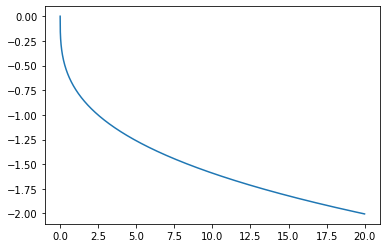

In [23]:
scaler_rho = np.arange(0, 20, 0.01)
plt.plot(scaler_rho, ker_lda_x(rs(scaler_rho), 0))

## VWN5 相关泛函

VWN5 积分是 LDA 方法中最常用的相关能计算方法。在 Gaussian 中，若打算仅仅计算 VWN5 相关能，输入卡中可以包含下述语句：

```
#p SVWN5/6-31G nosymm Integral(Grid=99590) IOp(3/74=1)
```

VWN5 的公式较为复杂，在此我们不打算从公式来给出程序实现；但会给出从 LibXC 代码转换到 Python 代码的过程。首先，我们进行一次 VWN5 的计算过程：

In [24]:
scf_eng_vwn = dft.RKS(mol)
scf_eng_vwn.xc = "VWN5"
scf_eng_vwn.grids = grids
scf_eng_vwn.kernel()

config = {"scf_eng": scf_eng_vwn}
scfh_vwn = GradSCF(config)

随后给出 VWN5 自洽场下的密度格点 `rho_vwn_0` $\rho_g$ 和泛函核格点 `exc_vwn` $f_g$。需要注意到，我们并没有更换分子，因此 `ao_0` $\phi_{g \mu}$ 其实没有变化，因此并不需要重新生成原子轨道的格点；但由于我们跑了一个新的自洽场，因此密度需要重新生成。

In [25]:
rho_vwn_0 = np.einsum("uv, gu, gv -> g", scfh_vwn.D, ao_0, ao_0)
exc_vwn = ni.eval_xc("VWN5", rho_vwn_0, deriv=0)[0]

我们的目标是通过 LibXC 改编的代码求出下面的相关能 $E_\mathrm{c}^\mathrm{VWN5} [\rho]$：

In [26]:
eng_xc_vwn = scf_eng_vwn.energy_elec()[0] - ((scfh_vwn.H_0_ao + 0.5 * scf_eng_vwn.get_j()) * scfh_vwn.D).sum()
eng_xc_vwn

-1.196157442939949

### 根据 LibXC 源代码给出泛函核

对于 VWN5 方法，其完整的计算过程除了需要各种泛函的基础 [util.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/util.mpl) 文件之外，还需要 VWN 相关泛函的基础 [vwn.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/vwn.mpl) 与 VWN5 泛函本身的定义文件 [lda_c_vwn.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/lda_c_vwn.mpl)。

通过 [util.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/util.mpl)，我们还需要定义一个函数 (但事实上，由于该函数只与自旋密度的标度有关，因此在 RKS 下，该函数始终返回零值)：

In [27]:
def f_zeta(z): return ((1 + z)**(4/3) + (1 - z)**(4/3) - 2)/(2**(4/3) - 2)

[vwn.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/vwn.mpl) 中的定义如下 (由于 Maple 是 1-Indexing，因此我们在 Python 代码中的所有 0 索引位用 `None` 填充)：

In [28]:
A_vwn  = [None,  0.0310907, 0.01554535, -1/(6*Pi**2)]
b_vwn  = [None,  3.72744,   7.06042,    1.13107  ]
c_vwn  = [None, 12.9352,   18.0578,    13.0045   ]
x0_vwn = [None, -0.10498,  -0.32500,   -0.0047584]

A_rpa  = [None,  0.0310907,  0.01554535,  -1/(6*Pi**2)]
b_rpa  = [None, 13.0720,    20.1231,      1.06835  ]
c_rpa  = [None, 42.7198,   101.578,      11.4813   ]
x0_rpa = [None, -0.409286,  -0.743294,   -0.228344 ]

def Q(b, c): return np.sqrt(4*c - b**2)
def f1(b, c): return 2*b/Q(b, c)
def f2(b, c, x0): return b*x0/(x0**2 + b*x0 + c)
def f3(b, c, x0): return 2*(2*x0 + b)/Q(b, c)
fpp = 4/(9*(2**(1/3) - 1))

def fx(b, c, rs): return rs + b*np.sqrt(rs) + c

def f_aux(A, b, c, x0, rs): return A*(
        + np.log(rs/fx(b, c, rs))
        + (f1(b, c) - f2(b, c, x0)*f3(b, c, x0))*np.arctan(Q(b, c)/(2*np.sqrt(rs) + b))
        - f2(b, c, x0)*np.log((np.sqrt(rs) - x0)**2/fx(b, c, rs))
    )

def DMC(rs, z): return(
    + f_aux(A_vwn[2], b_vwn[2], c_vwn[2], x0_vwn[2], rs)
    - f_aux(A_vwn[1], b_vwn[1], c_vwn[1], x0_vwn[1], rs)
)

从而 [lda_c_vwn.mpl](https://gitlab.com/libxc/libxc/blob/4.3.4/maple/lda_c_vwn.mpl) 就可以给出 VWN5 的泛函格点 $f_g$ 的函数了：

In [29]:
def ker_lda_c_vwn(rs, z): return(
    + f_aux(A_vwn[1], b_vwn[1], c_vwn[1], x0_vwn[1], rs)
    + f_aux(A_vwn[3], b_vwn[3], c_vwn[3], x0_vwn[3], rs)*f_zeta(z)*(1 - z**4)/fpp
    + DMC(rs, z)*f_zeta(z)*z**4
)

最终我们可以确认由 LibXC 改编的代码与 PySCF 生成的 $f_g$ 几乎是相等的；但由于数值问题，实际上比对的对象是 $f_g \rho_g$：

In [30]:
np.allclose(ker_lda_c_vwn(rs(rho_vwn_0), 0) * rho_vwn_0, exc_vwn * rho_vwn_0)

True

LibXC 改编代码给出的相关能 $E_\mathrm{c}^\mathrm{VWN5} [\rho] = w_g f_g \rho_g$ 为

In [31]:
(grids.weights * ker_lda_c_vwn(rs(rho_vwn_0), 0) * rho_vwn_0).sum()

-1.1961574429398458

### VWN5 相关泛函核的图像

与 Slater 泛函同样地，我们可以绘制 VWN5 相关泛函的图像如下；其中横坐标是密度 $\rho_g$ 的量纲 $[\mathrm{L}]^{-3}$，即玻尔半径的三次倒数；纵坐标是 $E_\mathrm{x}^\mathrm{Slater}$ 的量纲 $[\mathrm{M}][\mathrm{L}]^2[\mathrm{T}]^{-2}$，即 Hartree。

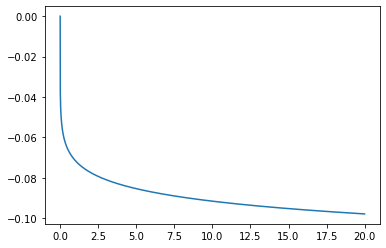

In [32]:
scaler_rho = np.arange(0, 20, 0.01)
plt.plot(scaler_rho, ker_lda_c_vwn(rs(scaler_rho), 0))

## 参考任务解答

### 任务 (1)

#### 任务 (1.1)

- Line 1：是为格点张量预留出足够的空间。

    - `grid_ao` 是三维张量，其中第一维度表示求导梯度，当取为 0, 1, 2, 3 时分别代表没有求导、$\partial_x$、$\partial_y$、$\partial_z$。
    
    - 第二维度是格点。
    
    - 第三维度是 AO 基组。在这篇文档中，我们只使用没有求导的部分，即 `grid_ao[0]` 或 `ao_0` $\phi_{g \mu}$；而被求导的部分则是 `grid_ao[1:4]` $\phi_{rg \mu} = \partial_r \phi_{g \mu}$。

- Line 2：指定每次迭代过程的格点起点指标 `g_start`、终点指标 `g_end`，以及给予分配内存的大小 `g_mem`。`g_start` 与 `g_end` 在后续迭代过程中会变更，但 `g_mem` 是固定值；`g_mem = 2000` 意指生成轨道格点过程预留 2000 MB。

- Line 3：对 `ni.block_loop` 返回的迭代器进行迭代。`ni.block_loop` 传入的第四个参数 `1` 指的是求轨道的一阶导数 $\phi_{rg \mu}$；若传入 `3` 则意为求三阶导数 $\phi_{tsrg \mu} = \partial_t \partial_s \partial_r \phi_{g \mu}$。该值也会对 `grid_ao` 应当具有的维度有所影响；当传入 `1` 时 `grid_ao` 的第一维度应当是 4，而传入 `3` 时则应当是 $1 + 3 + 6 + 10 = 20$。

- Line 4-5：根据 `ni.block_loop` 所给出的格点数量，向 `grid_ao`, `grid_weights`, `grid_coords` 等变量进行填充。

- 后面的代码便是填入张量，并且更新下一次迭代时的格点指标起点为这次迭代时的格点指标终点。

#### 任务 (1.2)

我们首先来看看不推荐使用的那一行代码是否能正常工作：

In [33]:
g_mem = 2000
grid_ao_wrong, _, grid_weights_wrong, grid_coords_wrong = next(ni.block_loop(mol, grids, nao, 1, g_mem))
print(np.allclose(grid_weights_wrong, grids.weights))
print(np.allclose(grid_coords_wrong, grids.coords))
print(grid_ao_wrong.shape)

True
True
(4, 130776, 22)


似乎工作一切正常。但是当 `g_mem` 非常小 (或者分子非常大) 时，就会发现 `ni.block_loop` 不会一次性给出所有格点：

In [34]:
g_mem = 10
grid_ao_wrong, _, grid_weights_wrong, grid_coords_wrong = next(ni.block_loop(mol, grids, nao, 1, g_mem))
print(grid_ao_wrong.shape)

(4, 7040, 22)


DFT 格点由于体积非常庞大，因此对于较大的分子或者交密集的格点，即使计算机的 RAM 再大也可能撑不住一次性在内存读入所有格点，更不提基于这些格点的运算了。所幸的是，对于任何格点积分运算，其中的一个格点的结果不会影响到另一个格点；或者说将 DFT 的总的格点进行分批 (batch) $g = \{ g_1, g_2, \cdots, g_n \}$，那么

$$
\int f(\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r} = \sum_g w_g f_g = \sum_{g} \sum_{i = 1}^{n} w_{g_i} f_{g_i}
$$

因此，在实际计算 DFT 格点积分时，一般地总是将格点按合理的内存空间大小分配 batch，对每个 batch 进行分别求和，最后将所有 batch 的结果求和就得到总的 DFT 格点积分了。若定义 `g_mem = 10`，则我们会分配内存大小使得对于每个 batch $g_i$ 有轨道格点 $\phi_{g_i \mu}$ 和轨道一阶导数格点 $\phi_{rg_i \mu}$ 的内存总占用量不大于 10 MB。

### 任务 (2)

#### 任务 (2.1)

$\rho_g$ 在每个格点上的元素的量纲是 $[\mathrm{L}]^{-3}$。

这里补充说明为何 $w_g$ 的量纲当作 $[\mathrm{L}]^{3}$。我们回到一维函数 $f(x)$ 的格点积分上。如果格点在 $x$ 轴上的分布是均匀的，每个格点之间的距离为 $\Delta x$，那么

$$
\int f(x) \, \mathrm{d} x \sim \sum_g f_g \Delta x
$$

此时充当权重的量便是 $\Delta x$，其量纲在一维空间下为 $[\mathrm{L}]$。推广到三维空间，则 $w_g$ 的量纲应当是 $[\mathrm{L}]$ 的三次方。

## 参考文献